<h1>
<center>Graph Construction </center>
</h1>

<font size="3">
<center>
The goal of this notebook is to transform the data so that it is in suitable format to be input to the temporal graph neural networks. 
<br>
In summary we convert to <b>Dynamic Graph with Temporal singal</b> format
</center>
</font>

<br>

<font size="3">
The notebook takes as input pandas DataFrames (training-set, validation-set, test-set)

    The notebook outputs multidimensional numpy arrays:
<ol>
<li>Edge Features with shape of: (timesteps, assets, features).</li>
<li>Edge Targets with shape of: (timesteps, assets, target).</li>
<li>Edges with shape of (timesteps, 2, assets*assets).</li>
<li>Edge Weights with shape of (timesteps, assets*assets).</li>
</font>

## Generals 

<font size="3"> 
Packages import and system configurations. 
</font>

In [1]:
#Data
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import shutil
import math
from datetime import datetime
#Graph Counstruction
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy import *

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch.nn import Linear
from torch.nn import ReLU
import torch.nn as nn
from torch.nn.init import kaiming_uniform_

<font size="3"> 
Define necessary paths. 
</font>

In [2]:
train_path = 'io/input/base_data/train.csv'
test_path = 'io/input/base_data/test.csv'
val_path ='io/input/base_data/valid.csv'

data_intermediate_path = 'io/input/data_intermediate/'
granger_results_path = data_intermediate_path + 'granger_results/'

train_node_features_path = data_intermediate_path + 'node_features/train/'
train_node_labels_path = data_intermediate_path + 'node_labels/train/'
train_edges_path = data_intermediate_path + 'edges/train/'
train_edge_weights_path = data_intermediate_path + 'edge_weights/train/'

val_node_labels_path = data_intermediate_path + 'node_labels/val/'
val_node_features_path = data_intermediate_path + 'node_features/val/'
val_edges_path = data_intermediate_path + 'edges/val/'
val_edge_weights_path = data_intermediate_path + 'edge_weights/val/'

test_node_labels_path = data_intermediate_path + 'node_labels/test/'
test_node_features_path = data_intermediate_path + 'node_features/test/'
test_edges_path = data_intermediate_path + 'edges/test/'
test_edge_weights_path = data_intermediate_path + 'edge_weights/test/'

plot_export_path = 'io/output/exports/analysis_plots/'
chunk_size = 10000
train_timesteps = 100000
val_timesteps = 1000000
test_timesteps = 100000
total_timesteps = train_timesteps + val_timesteps + test_timesteps

## Core Functionality

<font size="3"> 
Save numpy arrays on chunks. 
</font>

In [3]:
def save_object(arr,chunk_size,path):
    num_chunks = arr.shape[0] // chunk_size + 1
    shutil.rmtree(path, ignore_errors=True)
    os.makedirs(path)
    for i in tqdm(range(num_chunks)):
        chunk = arr[i*chunk_size:(i+1)*chunk_size, :]
        filename = f"{path}chunk_{i}.npy"
        np.save(filename, chunk)

<font size="3"> 
Load numpy arrays on chunks. 
</font>

In [4]:
def load_object(path):
    num_chunks = len([f for f in os.listdir(path) if f.startswith('chunk_') and f.endswith('.npy')])
    # Load array from chunks
    chunks = []
    for i in range(num_chunks):
        filename = f"{path}chunk_{i}.npy"
        print()
        chunk = np.load(filename,allow_pickle=True)
        chunks.append(chunk)
    arr_reconstructed = np.concatenate(chunks, axis=0)
    return arr_reconstructed

### Data Preprocesing

<font size="3"> 
Load and preprocess dataframes. 
</font>

In [5]:
def load_data(train_path,val_path,test_path):
    trainset = pd.read_csv(train_path,index_col=0)
    trainset = convert_index(trainset)
    
    testset = pd.read_csv(test_path,index_col=0)
    testset = convert_index(testset)
    
    valset = pd.read_csv(val_path,index_col=0)
    valset = convert_index(valset)
    
    trainset_full = pd.concat([trainset, valset], ignore_index=True)
    trainset_full,scaller = scalle_df(trainset_full,None)    
    trainset,scaller1 = scalle_df(trainset,scaller)
    testset,scaller1 = scalle_df(testset,scaller)
    valset,scaller1 = scalle_df(valset,scaller)
    return trainset,valset,testset

<font size="3"> 
Apply Standardization. 
</font>

In [6]:
def scalle_df(df,scaller):
    cols_to_scale = df.columns.difference(["Date","Asset_id","Target"])
    if scaller == None:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[cols_to_scale])
    else:
        scaled_data = scaler.transform(df[cols_to_scale])
    cols_to_scale = df.columns.difference(["Date","Asset_id","Target"])
    scaled_df = pd.DataFrame(scaled_data, columns=cols_to_scale)
    scaled_df = pd.concat([df["Date"], scaled_df, df["Asset_id"],df["Target"]], axis=1)
    return scaled_df,scaller

<font size="3"> 
Convert index to datetime. 
</font>

In [7]:
def convert_index(df): 
    df['Date'] = df.index
    df.reset_index(inplace=True,col_fill=['Date'])
    df = df.drop(['index'], axis=1) 
    df['Date'] = pd.to_datetime(df['Date'])
    return df

## Graph info construction

<font size="3">
At this part we convert the dataframes to be suitalble for graph neural networks input. Finaly we construct:
<ol>
<li>Node features.</li>
<li>Node Targes.</li>
<li>Edges.</li>
<li>Edge Weights.</li>
        
    
    Process have applied both of train, validation and test sets

<font size="3"> 
Node features construction. 
</font>

In [8]:
def node_features_construction(df,timesteps):
    feature_names = df.columns   
    # Get a list of all unique asset IDs in the dataset
    asset_ids = df['Asset_id'].unique()
    dates = sorted(df['Date'].unique())

    # Get a list of all features in the dataset
    features = list(df.columns)
    features.remove('Date')
    features.remove('Asset_id')
    features.remove('Target')
    
    # Experiment with Crypto One hot,
    # feature_list = ['Close', 'Day_cos', 'Day_sin', 'High', 'Hour_cos', 'Hour_sin', 'Low', 'Month_cos', 'Month_sin', 'Open', 'Volume', 'Year_cos', 'Year_sin']
    # Experiment with Crypto One hot, Temporal
    # feature_list = ['Close', 'Open', 'High', 'Low', 'Volume']
    # Experiment with Crypto One hot, Temporal, High-Low
    # feature_list = ['Close', 'Open', 'Volume']
    # Experiment with Crypto One hot, Temporal, High-Low, Open-Close
    # feature_list = ['Volume']
    # Experiment with Crypto One hot, Temporal, High-Low, Open-Close, Volume
    feature_list = []
    
    for feature in feature_list:
        features.remove(feature)
    
    results=[]
    results=[0 for i in range(len(dates))]

    for i in tqdm( range (0,len(dates))):
        results[i] = df[df["Date"]==dates[i]]
        results[i] = results[i].sort_values('Asset_id', ascending=True)
        results[i] = results[i].drop(['Date'], axis=1)
        results[i] = results[i].drop(['Asset_id'], axis=1)
        results[i] = results[i].drop(['Target'], axis=1)

        results[i] = results[i].drop(feature_list, axis=1)

    results = results[:timesteps]
    np_result = np.array(results)
    np_result = np.reshape(np_result, (len(results),len(asset_ids),len(features),1))
    return np_result

<font size="3"> 
Node Labels construction. 
</font>

In [9]:
def node_labels_construction(df,timesteps):
    asset_ids = df['Asset_id'].unique()
    dates = sorted(df['Date'].unique())
    dates = dates[:timesteps]
    df = df.sort_values('Date', ascending=True)
    df = df.loc[df['Date'].isin(dates)].reset_index(drop=True)
    result = df.pivot(index='Date', columns='Asset_id', values='Target')
    result = np.array(result)
    result = np.reshape(result, (len(result), len(asset_ids),1))
    return result

### Edge Info 

<font size="3">
We Create directed edges and edge weights between assets based on the Granger causality values, using target's times-series.
<br>
<br>
This Funciton Perform a Granger causality test on a DataFrame containing time series data for multiple assets and finally create the adjacency matrixes for each timesteps while:
<ol>
<li>Loop through each pair of asset IDs and calculate the Granger causality in both directions using the grangercausalitytests function.</li>
<li>Add the maximum F statistic value to the adjacency matrix if there is data available for the pair of asset IDs.</li>
<li>Return a list of adjacency matrices for each timestamp, as well as a list of asset IDs and a list of dates.</li>
<li>Edge Weights.</li>

In [10]:
def adjency_matrixes_granger_test(df,timsteps):
    df_pivot = df.pivot_table(index='Date', columns='Asset_id', values='Target')
    df_pivot = df_pivot.head(timsteps)
    date_list = df_pivot.index
    asset_ids = df_pivot.columns
    # Create an empty list to store the adjacency matrices
    adj_matrices = []

    # Loop through each timestamp
    for i in tqdm (range (len(df_pivot))):

        # Select the data up to the current timestamp
        data = df_pivot.iloc[:i+1,:]
        
        # Create an empty adjacency matrix for the current timestamp
        adj_matrix = np.zeros((len(df_pivot.columns), len(df_pivot.columns)))

        # Loop through each combination of asset IDs
        for j in range(len(df_pivot.columns)):
            for k in range(len(df_pivot.columns)):

                # Skip if j and k are the same asset ID
                if j == k:
                    continue

                # Select the data for the current pair of asset IDs
                data_jk = data.iloc[:,[j,k]].dropna()

                # Skip if there is no data for the current pair of asset IDs
                if len(data_jk) == 0:
                    continue

                # Calculate Granger causality in both directions between j and k
                try:
                    result1 = grangercausalitytests(data_jk, maxlag=1, verbose=False)
                    max_F_statistic1 = max(result1[lag][0]['params_ftest'][0] for lag in result1.keys())
                except:
                    max_F_statistic1 = None

                # Add the Granger causality values to the adjacency matrix
                if max_F_statistic1 is not None: #and max_F_statistic2 is not None:
                    adj_matrix[j,k] = max_F_statistic1

        # Add the current adjacency matrix to the list of adjacency matrices
        adj_matrices.append(adj_matrix)
    return adj_matrices,asset_ids,date_list

<font size="3"> 
Split edge weights adjacency matrixes to train, validation and test sets. 
</font>

In [11]:
def split_adjency_matrixes(x,y,z1,z2,z3):
    x1,x2,x3 = [],[],[]
    # Iterate through the names and dates in x and y
    for i in range(x.shape[0]):
        name = x[i]
        date = y[i]
        # Determine which array to append the name to based on its date
        date_obj = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        # Determine which array to append the name to based on its date
        if pd.Series(date).isin(z1).any():
            x1.append(name)
        if pd.Series(date).isin(z2).any():
            x2.append(name)
        if pd.Series(date).isin(z3).any():
            x3.append(name)
    return np.array(x1),np.array(x2),np.array(x3)

<font size="3"> 
Nomalize edge weights to range 0.1-0.9.
</font>

In [12]:
def normalize_adj(adjency_matrixes):
    norm_adjency_matrixes = []
    for adj in tqdm(adjency_matrixes):
        # Create a copy of the input matrix
        adj_norm = np.copy(adj)
        # Get the diagonal indices
        diag_indices = np.diag_indices(adj.shape[0])
        # Set the diagonal elements to 1
        adj_norm[diag_indices] = 1
        # Normalize the non-diagonal elements on the range 0.1-0.9
        non_diag_mask = np.ones(adj.shape, dtype=bool)
        non_diag_mask[diag_indices] = False
        adj_norm[non_diag_mask] = 0.1 + 0.8 * (adj_norm[non_diag_mask] - np.min(adj_norm[non_diag_mask])) / (np.max(adj_norm[non_diag_mask]) - np.min(adj_norm[non_diag_mask]))
        norm_adjency_matrixes.append(adj_norm)
    norm_adjency_matrixes = np.array(norm_adjency_matrixes)
    return norm_adjency_matrixes

<font size="3"> 
Convert edges and edge-weights to the final format (multy-dimensional numpy arrays).
</font>

In [13]:
def adj_to_edge_lists(norm_adjency_matrixes):
    undirected_edges_list = []
    undirected_weights_list = [] 
    
    for adj_matrix in tqdm(norm_adjency_matrixes):
        edges = np.transpose(np.where(adj_matrix != 0))
        edge_weights = adj_matrix[edges[:, 0], edges[:, 1]]
        edges = [list(edges[:, 0] + 1), list(edges[:, 1] + 1)]
        edg_weights = list(edge_weights)
        undirected_edges_list.append(edges)
        undirected_weights_list.append(edge_weights)
    
    undirected_edges_list = np.array(undirected_edges_list)
    undirected_edges_list = undirected_edges_list - 1
    undirected_weights_list = np.array(undirected_weights_list)
    where_are_NaNs = isnan(undirected_weights_list)
    undirected_weights_list[where_are_NaNs] = 0
    return undirected_edges_list,undirected_weights_list

<font size="3"> 
Plot adjency matrixes of the edges.
</font

In [14]:
def plot_adjency_matrixes(adj_matrix1,adj_matrix2,labels,date1,date2,plot_export_path):
    # Create two random adjacency matrices
    labels = asset_ids
    # Set up the figure and two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    # Plot the first adjacency matrix
    im1 = ax1.imshow(adj_matrix1, cmap='coolwarm', interpolation='None')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_yticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels,rotation=90)
    ax1.set_yticklabels(labels)
    ax1.tick_params(axis='both', labelsize=12)
    ax1.set_title(date1)
    # Plot the second adjacency matrix
    im2 = ax2.imshow(adj_matrix2, cmap='coolwarm', interpolation='None')
    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_yticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels,rotation=90)
    ax2.set_yticklabels(labels)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.set_title(date2)
    # Add the matrix values as text to the plots
    for ax, adj_matrix in zip([ax1, ax2], [adj_matrix1, adj_matrix2]):
        for i in range(adj_matrix.shape[0]):
            for j in range(adj_matrix.shape[1]):
                text = ax.text(j, i, round(adj_matrix[i, j],1),
                               ha="center", va="center", color="w", fontsize=12)
    # Set the title of the figure
    fig.suptitle("Dynamic Graph Edge Info", fontsize=18)
    # Adjust the spacing between subplots
    fig.tight_layout(pad=2)
    # Display the plot
    plt.savefig(plot_export_path + 'Adjency_Matrixes.png')
    plt.show()

## Pipeline Execution

<font size="3"> 
Node Features and Nodel labels construction and save 
</font

In [15]:
trainset,valset,testset = load_data(train_path,val_path,test_path)

# Train-set
print('Construction: train node features')
train_node_features = node_features_construction(trainset,train_timesteps)
save_object(train_node_features,chunk_size,train_node_features_path)

print('Construction: train node labels')
train_node_labels = node_labels_construction(trainset,train_timesteps)
save_object(train_node_labels,chunk_size,train_node_labels_path)

# Validation-set
print('Construction: val node features')
val_node_features = node_features_construction(valset,val_timesteps)
save_object(val_node_features,chunk_size,val_node_features_path)

print('Construction: val node labels')
val_node_labels = node_labels_construction(valset,val_timesteps)
save_object(val_node_labels,chunk_size,val_node_labels_path)

# Test-set
print('Construction: test node features')
test_node_features = node_features_construction(testset,test_timesteps)
save_object(test_node_features,chunk_size,test_node_features_path)

print('Construction: test node labels')
test_node_labels = node_labels_construction(testset,test_timesteps)
save_object(test_node_labels,chunk_size,test_node_labels_path)

Construction: train node features


100%|██████████| 1/1 [00:00<00:00, 143.07it/s]


Construction: train node labels


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Construction: val node features


100%|██████████| 1/1 [00:00<00:00, 335.92it/s]


Construction: val node labels


100%|██████████| 1/1 [00:00<00:00, 513.25it/s]


Construction: test node features


100%|██████████| 1/1 [00:00<00:00, 508.65it/s]


Construction: test node labels


100%|██████████| 1/1 [00:00<00:00, 986.20it/s]


### Create and saved edges and edge-weights 

<font size="3"> 
Edges and Edge-Weights construction and save 
</font

In [16]:
#Load Datasets
trainset,valset,testset = load_data(train_path,val_path,test_path)
train_dates,validation_dates,test_dates = trainset['Date'].tolist(),valset['Date'].tolist(),testset['Date'].tolist()
frames = [trainset,valset,testset]
full_dataset = pd.concat(frames)


# (!) -----> Apply Grager Casuality test.
# (!) -----> Grager Casualty test was very time consuming so we have do it once and save the results. 


# adjency_matrixes,asset_ids,dates = adjency_matrixes_granger_test(full_dataset,total_timesteps)

# print('Save: Grager results')
# save_object(np.array(adjency_matrixes),chunk_size,granger_results_path)
# with open(granger_results_path + 'asset_ids.pkl', 'wb') as f:
#     pd.to_pickle(asset_ids, f)
# with open(granger_results_path + 'date.pkl', 'wb') as f:
#     pd.to_pickle(dates, f)

print('Load: Grager results')
adjency_matrixes = load_object(granger_results_path)
with open(granger_results_path + 'asset_ids.pkl', 'rb') as f:
    asset_ids = pd.read_pickle(f)
with open(granger_results_path + 'date.pkl', 'rb') as f:
    dates = pd.read_pickle(f)


norm_adjency_matrixes = normalize_adj(adjency_matrixes)
undirected_edges,undirected_weights = adj_to_edge_lists(norm_adjency_matrixes)
train_undirected_edges,val_undirected_edges,test_undirected_edges = split_adjency_matrixes(undirected_edges,dates,train_dates,validation_dates,test_dates)
train_undirected_weights,val_undirected_weights,test_undirected_weights = split_adjency_matrixes(undirected_weights,dates,train_dates,validation_dates,test_dates)

# Train-set
print('Save: train edge info')
save_object(train_undirected_edges,chunk_size,train_edges_path)
save_object(train_undirected_weights,chunk_size,train_edge_weights_path)

# Validation-set
print('Save: val edge info')
save_object(val_undirected_edges,chunk_size,val_edges_path)
save_object(val_undirected_weights,chunk_size,val_edge_weights_path)

# Test-set
print('Save: test edge info')
save_object(test_undirected_edges,chunk_size,test_edges_path)
save_object(test_undirected_weights,chunk_size,test_edge_weights_path)

Load: Grager results



  0%|          | 0/7997 [00:00<?, ?it/s]C:\Users\My Laptop\AppData\Local\Temp\ipykernel_16164\2537035348.py:13: RuntimeWarning: invalid value encountered in divide
  adj_norm[non_diag_mask] = 0.1 + 0.8 * (adj_norm[non_diag_mask] - np.min(adj_norm[non_diag_mask])) / (np.max(adj_norm[non_diag_mask]) - np.min(adj_norm[non_diag_mask]))
100%|██████████| 7997/7997 [00:00<00:00, 23861.81it/s]


Save: train edge info


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


Save: val edge info


100%|██████████| 1/1 [00:00<00:00, 496.37it/s]


Save: test edge info


100%|██████████| 1/1 [00:00<00:00, 334.31it/s]


<font size="3"> 
Plot adjacency matrixes for comparison purposes 
</font>

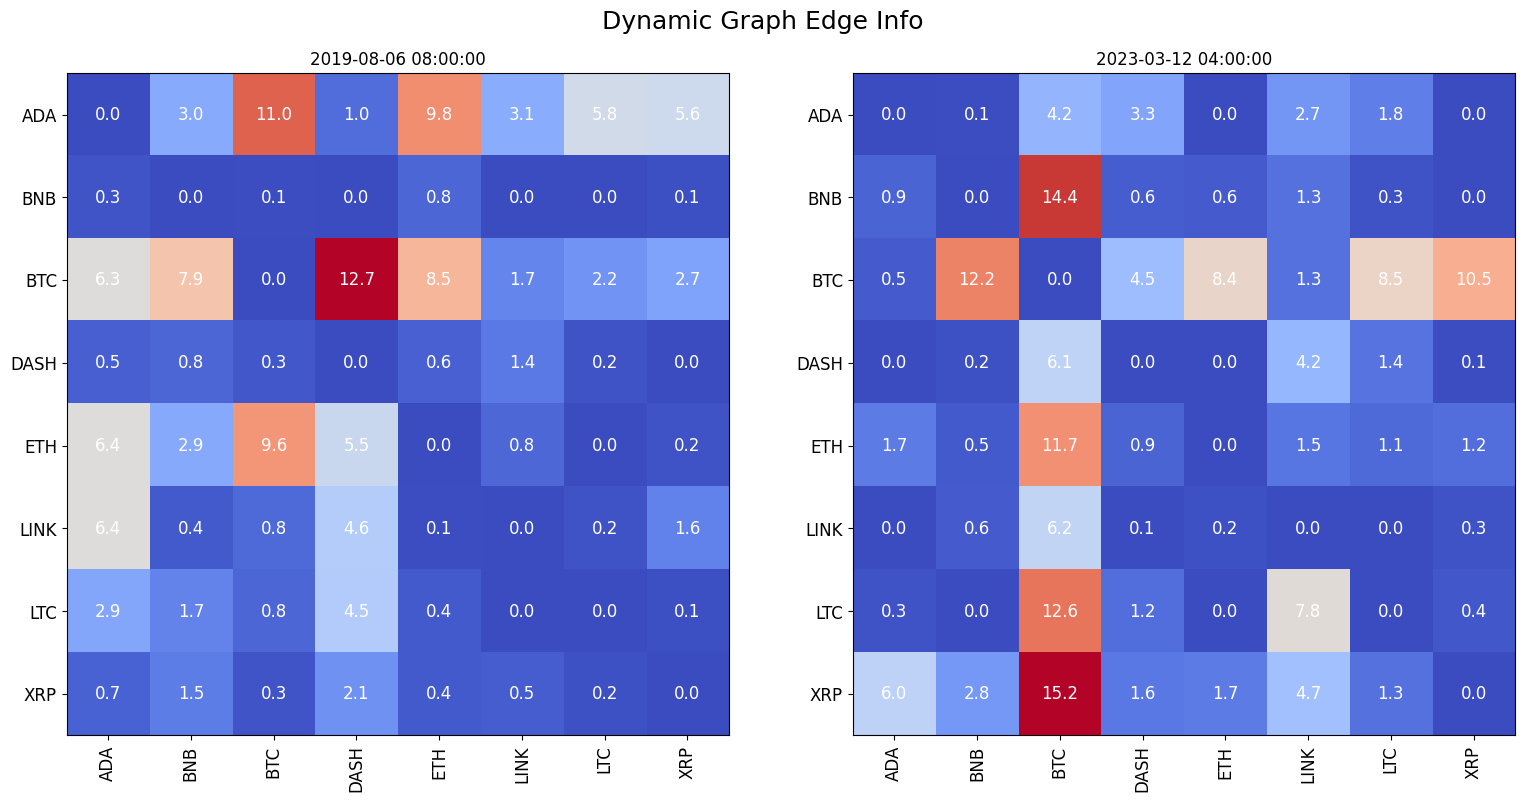

In [17]:
plot_adjency_matrixes(adjency_matrixes[100],adjency_matrixes[-16],asset_ids,dates[100],dates[-16],plot_export_path)


OSError: [Errno 22] Invalid argument: 'io/output/exports/analysis_plots/2019-08-06 08:00:00Adjency_Matrix.png'

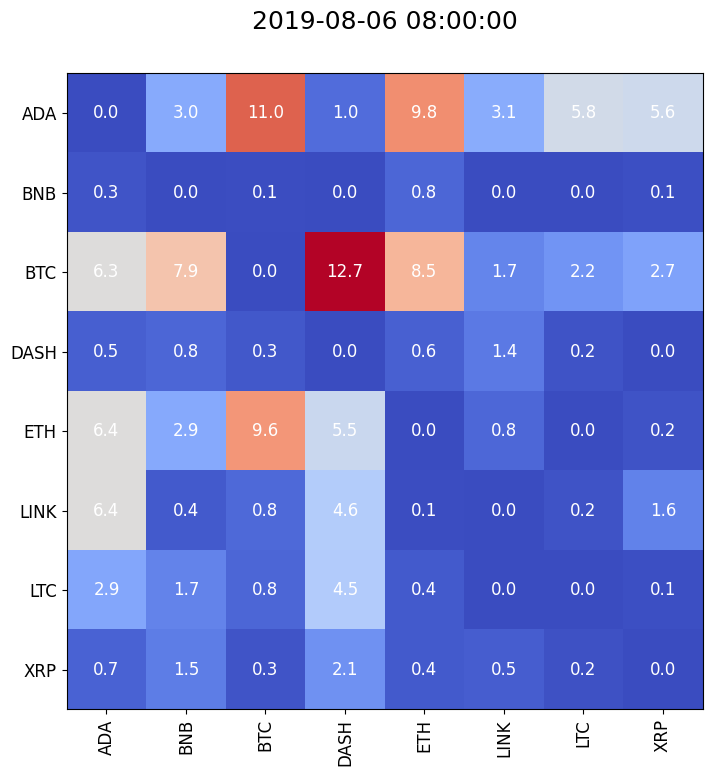

In [18]:
def plot_adjency_matrix(adj_matrix, labels, date, plot_export_path):
    # Create a random adjacency matrix
    labels = asset_ids
    # Set up the figure
    fig, ax = plt.subplots(figsize=(16, 8))
    # Plot the adjacency matrix
    im = ax.imshow(adj_matrix, cmap='coolwarm', interpolation='None')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels,rotation=90)
    ax.set_yticklabels(labels)
    ax.tick_params(axis='both', labelsize=12)
    #ax.set_title(date)
    # Add the matrix values as text to the plot
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            text = ax.text(j, i, round(adj_matrix[i, j],1),
                           ha="center", va="center", color="w", fontsize=12)
    # Set the title of the figure
    fig.suptitle(date, fontsize=18)
    # Adjust the spacing between subplots
    fig.tight_layout(pad=2)
    # Display the plot
    plt.savefig(plot_export_path + str(date)+'Adjency_Matrix.png', pad_inches=0, dpi=300,format='png')
    plt.show()

# Call the function for the first adjacency matrix
plot_adjency_matrix(adjency_matrixes[100],asset_ids,dates[100],plot_export_path,)

# Call the function for the second adjacency matrix
plot_adjency_matrix(adjency_matrixes[300],asset_ids,dates[300],plot_export_path)

plot_adjency_matrix(adjency_matrixes[5000],asset_ids,dates[5000],plot_export_path)